# Description

This work deals with the classification of handwritten numbers by a fully connected neural network (using GPU).

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.datasets

import warnings
warnings.filterwarnings("ignore")

# Tasks

Task 1. Classify images using a fully connected neural network (MNIST dataset).

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

__Data preparation__

In [3]:
mnist_train = torchvision.datasets.MNIST('./', download=True, train=True);
mnist_test = torchvision.datasets.MNIST('./', download=True, train=False);
X_train = mnist_train.train_data
y_train = mnist_train.train_labels
X_test = mnist_test.test_data
y_test = mnist_test.test_labels

In [4]:
# X_train and y_train dtypes
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [5]:
# for greater accuracy in calculations
X_train = X_train.float()
X_test = X_test.float()

In [6]:
# datasets shapes
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


tensor(5)


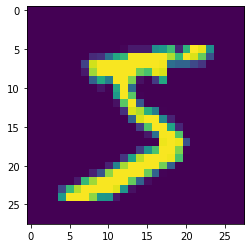

In [7]:
# display an example of the data
plt.imshow(X_train[0, :, :])
print(y_train[0])

In [8]:
# unrolling parameters
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [9]:
# updated datasets shapes
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([60000, 784]) torch.Size([10000, 784])
torch.Size([60000]) torch.Size([10000])


__Model__

In [10]:
class MNISTNet(torch.nn.Module):
    
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

In [11]:
mnist_net = MNISTNet(100)
mnist_net

MNISTNet(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (ac1): Sigmoid()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

__Loss and optimizer__

In [12]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

__Device__

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
X_test = X_test.to(device)
y_test = y_test.to(device)
mnist_net = mnist_net.to(device)

__Model training__

In [15]:
batch_size = 100
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    train_loss_history.append(loss_value)

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)

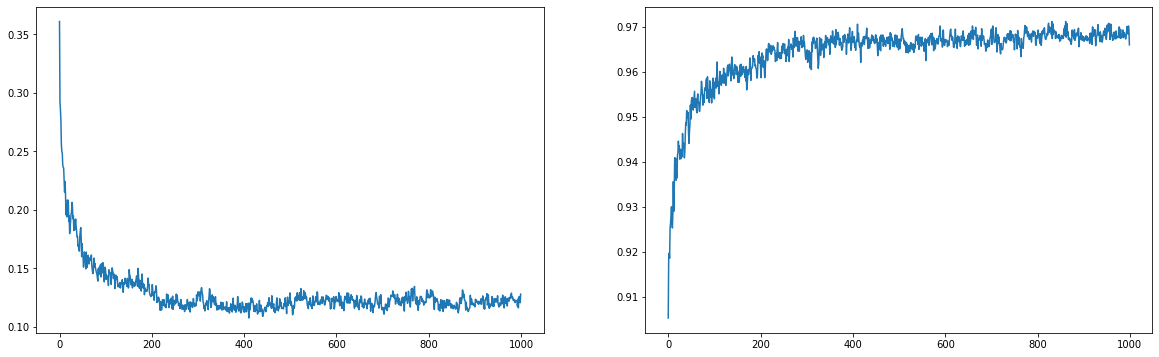

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(test_loss_history)
ax[0].title.set_text('Loss history')

ax[1].plot(test_accuracy_history)
ax[1].title.set_text('Accuracy history')

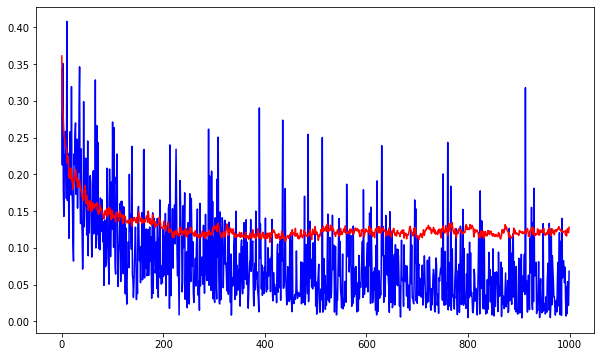

In [17]:
fig = plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, 'b')
plt.plot(test_loss_history, 'r')
plt.title('Train and test loss')

Task 2. Implement the functionality of torch.nn.Linear from scratch and compare with the original.

In [18]:
class linear_transformation():
    
    def __init__(self, in_features, out_features, bias=True):
        self.in_features = in_features
        self.out_features = out_features
        self.bias = np.ones((self.out_features)) if bias else None
        self.W = np.ones((self.in_features, self.out_features))

    def forward(self, X):
        if self.bias is not None:
            self.Y = X.dot(self.W) + self.bias
        else:
            self.Y = X.dot(self.W)
        return self.Y

In [19]:
# implemented functionality
lin_obj = linear_transformation(100, 50)
x = np.ones((100))
y = lin_obj.forward(x)

# original functionality
lin_obj_torch = torch.nn.Linear(100, 50)
x_torch = torch.Tensor(np.ones((100)))
y_torch = lin_obj_torch.forward(x_torch)

# comparison
print(y.shape, y_torch.shape)

(50,) torch.Size([50])


Task 3. Suppose we have 1 object x at the input with two components. We will transfer it to a fully connected layer with 3 neurons and get 3 outputs. Then write the same functionality using matrix multiplication. And check the calculation of the derivative.

In [20]:
x = torch.tensor([[10., 20.]])
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
b = torch.tensor([[31., 32., 33.]])

In [21]:
# original fc layer
fc = torch.nn.Linear(2, 3)
fc.weight.data = w
fc.bias.data = b
fc_out = fc(x)
fc_out_summed = fc_out.sum()
fc_out_summed.backward()

weight_grad = fc.weight.grad
bias_grad = fc.bias.grad

In [22]:
# matrix multiplication
w.requires_grad_(True)
b.requires_grad_(True)

fc_out_alternative = torch.matmul(x, torch.transpose(w, 0, 1)) + b
fc_out_alternative__summed = fc_out_alternative.sum()
fc_out_alternative__summed.backward()

In [23]:
# check the match
print(fc_out == fc_out_alternative)
print('fc_weight_grad:', weight_grad)
print('our_weight_grad:', w.grad)
print('fc_bias_grad:', bias_grad)
print('out_bias_grad:', b.grad)

tensor([[True, True, True]])
fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([[1., 1., 1.]])
out_bias_grad: tensor([[1., 1., 1.]])


Task 4. Classify images using a fully connected neural network (CIFAR10 dataset).

__Data preparation__

In [2]:
cifar_train = torchvision.datasets.CIFAR10('./', download=True, train=True);
cifar_test = torchvision.datasets.CIFAR10('./', download=True, train=False);
X_train = torch.Tensor(cifar_train.data)
y_train = torch.LongTensor(cifar_train.targets)
X_test = torch.Tensor(cifar_test.data)
y_test = torch.LongTensor(cifar_test.targets)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [3]:
# datasets shapes
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([50000, 32, 32, 3]) torch.Size([10000, 32, 32, 3])
torch.Size([50000]) torch.Size([10000])


In [4]:
X_train /= 255
X_test /= 255

In [5]:
cifar_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(9)


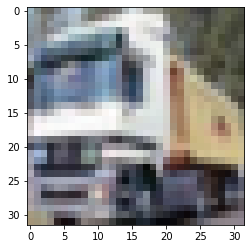

In [6]:
# display an example of the data
plt.imshow(X_train[1, :, :, :])
print(y_train[1])

In [7]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [8]:
# unrolling parameters
X_train = X_train.reshape([-1, 32 * 32 * 3])
X_test = X_test.reshape([-1, 32 * 32 * 3])

In [9]:
# updated datasets shapes
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([50000, 3072]) torch.Size([10000, 3072])
torch.Size([50000]) torch.Size([10000])


__Model__

In [10]:
class CIFARNet(torch.nn.Module):
    
    def __init__(self, n_hidden_neurons):
        super(CIFARNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(32*32*3, n_hidden_neurons)
        self.do1 = torch.nn.Dropout(0.4)
        self.bn1 = torch.nn.BatchNorm1d(n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()

        self.fc2 = torch.nn.Linear(n_hidden_neurons, 100)
        self.do2 = torch.nn.Dropout(0.2)
        self.bn2 = torch.nn.BatchNorm1d(100)
        self.ac2 = torch.nn.ReLU()

        self.fc3 = torch.nn.Linear(100, 10)


        
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.do1(x)
        x = self.bn1(x)
        x = self.ac1(x)

        x = self.fc2(x)
        x = self.do2(x)
        x = self.bn2(x)
        x = self.ac2(x)
                     
        x = self.fc3(x)
        
        return x

In [11]:
cifar_net = CIFARNet(250)
cifar_net

CIFARNet(
  (fc1): Linear(in_features=3072, out_features=250, bias=True)
  (do1): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=250, out_features=100, bias=True)
  (do2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

__Loss and optimizer__

In [12]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cifar_net.parameters(), lr=1.0e-3)

__Device__

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
X_test = X_test.to(device)
y_test = y_test.to(device)
cifar_net = cifar_net.to(device)

__Model training__

In [16]:
batch_size = 100
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

for epoch in range(200):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = cifar_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    train_loss_history.append(loss_value)

    test_preds = cifar_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)

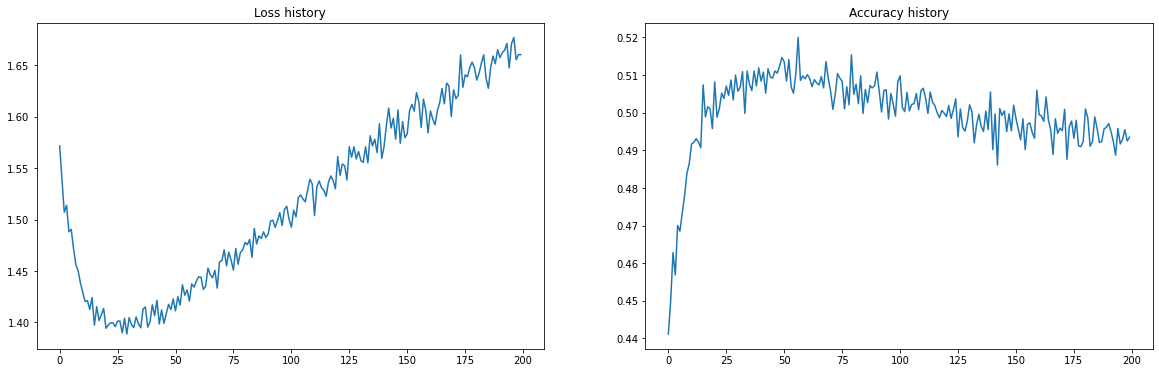

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(test_loss_history)
ax[0].title.set_text('Loss history')

ax[1].plot(test_accuracy_history)
ax[1].title.set_text('Accuracy history')

__Conclusion.__ The graph shows that the loss curve after the 30th epoch begins to rise, not fall. After several experiments with the model, the situation did not change. Thus, our model has limitations and is not suitable for this task (it is necessary to pay attention to convolutional neural networks).